In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import sklearn
from copy import deepcopy
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

## Data

In [2]:
# url = 'https://raw.githubusercontent.com/k4t0mono/hashtag_analysis/master/data_log.csv'
dataset = pd.read_csv('data_log.csv')

with_std = [ 'std' in x for x in dataset.columns]
with_std = np.extract(with_std, dataset.columns)
print(with_std)
# dataset.drop(with_std, axis=1, inplace=True)
dataset.drop(['total_users'], axis=1, inplace=True)

train_dataset = dataset.sample(frac=0.8, random_state=0xe621)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('total_tweets')
train_db = train_dataset.pop('db')
test_labels = test_dataset.pop('total_tweets')
test_db = test_dataset.pop('db')

['tweet_per_user_std_0' 'tweet_fav_std_0' 'tweet_rt_std_0'
 'tweet_per_user_std_1' 'tweet_fav_std_1' 'tweet_rt_std_1'
 'tweet_per_user_std_2' 'tweet_fav_std_2' 'tweet_rt_std_2'
 'tweet_per_user_std_3' 'tweet_fav_std_3' 'tweet_rt_std_3'
 'tweet_per_user_std_4' 'tweet_fav_std_4' 'tweet_rt_std_4']


In [3]:
train_stats = train_dataset.describe().transpose()
train_labels_stats = train_labels.describe().transpose()
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def denorm(z):
    return z * train_labels_stats['std'] + train_labels_stats['mean']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Graphs

In [4]:
def plot_prediction(test_labels, test_predictions):
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [log(x)]')
    plt.ylabel('Predictions [log(x)]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-5, 5], [-5, 5])

In [5]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    #   plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    #   plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label='Val Loss')
    plt.legend()

    plt.show()

## Neural Network

In [6]:
def build_model(hidden_layers, std=False):
    shape = len(train_dataset.keys())
        
    layers = [
        tf.keras.layers.Dense(41, activation='relu', input_shape=[shape])
    ]
    
    for layer_config in hidden_layers:
        if len(layer_config) == 1:
            size, activation = layer_config[0], 'relu'
        else:
            size, activation = layer_config
        
        layers.append(tf.keras.layers.Dense(size, activation=activation))
    
    layers.append(tf.keras.layers.Dense(1))
    
    model = tf.keras.Sequential(layers)

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae', 'mse']
    )
    
    return model

In [7]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

### 82 on the hidden

In [8]:
nnr_82 = build_model([ (82, 'relu') ])

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_82.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.................................................

### 41 on the hidden

In [9]:
nnr_41 = build_model([ (41, 'relu') ], True)

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_41.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


...........................................................................................

### 20 on the hidden

In [10]:
nnr_20 = build_model([ (20, 'relu') ], True)

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_20.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.......................................................................................

## Regression Tree

### Default

In [11]:
tr_default = DecisionTreeRegressor(criterion='mse', max_features=1)
tr_default = tr_default.fit(normed_train_data, train_labels)

### Depth 3 Features 1

In [12]:
tr_d3f1 = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=1)
tr_d3f1 = tr_d3f1.fit(normed_train_data, train_labels)

### Depth 3 Features 3

In [13]:
tr_d3f3 = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=1)
tr_d3f3 = tr_d3f3.fit(normed_train_data, train_labels)

## Support Vector Regression

### RBF

In [14]:
svr_rbf = SVR(kernel='rbf', gamma='scale')
svr_rbf = svr_rbf.fit(normed_train_data, train_labels)

### Polynomial

In [15]:
svr_poly = SVR(kernel='poly', gamma='scale')
svr_poly = svr_poly.fit(normed_train_data, train_labels)

### Linear

In [16]:
svr_linear = SVR(kernel='linear', gamma='scale')
svr_linear = svr_linear.fit(normed_train_data, train_labels)

## Linear Model

## Ordinary Least Squares

In [17]:
linear_reg = LinearRegression()
linear_reg = linear_reg.fit(normed_train_data, train_labels)

## Results

In [18]:
predicts = {
    'nnr_82_test': nnr_82.predict(normed_test_data),
    'nnr_82_train': nnr_82.predict(normed_train_data),
    'nnr_41_test': nnr_41.predict(normed_test_data),
    'nnr_41_train': nnr_41.predict(normed_train_data),
    'nnr_20_test': nnr_20.predict(normed_test_data),
    'nnr_20_train': nnr_20.predict(normed_train_data),
    'tr_default_test': tr_default.predict(normed_test_data),
    'tr_default_train': tr_default.predict(normed_train_data),
    'tr_d3f1_test': tr_d3f1.predict(normed_test_data),
    'tr_d3f1_train': tr_d3f1.predict(normed_train_data),
    'tr_d3f3_test': tr_d3f3.predict(normed_test_data),
    'tr_d3f3_train': tr_d3f3.predict(normed_train_data),
    'svr_rbf_test': svr_rbf.predict(normed_test_data),
    'svr_rbf_train': svr_rbf.predict(normed_train_data),
    'svr_poly_test': svr_poly.predict(normed_test_data),
    'svr_poly_train': svr_poly.predict(normed_train_data),
    'svr_linear_test': svr_linear.predict(normed_test_data),
    'svr_linear_train': svr_linear.predict(normed_train_data),
    'linear_reg_test': linear_reg.predict(normed_test_data),
    'linear_reg_train': linear_reg.predict(normed_train_data),
}

labels = {
    'test': test_labels,
    'train': train_labels,
}

In [19]:
data = []
for c in [ 'nnr_82', 'nnr_41', 'nnr_20', 'tr_default', 'tr_d3f1', 'tr_d3f3', 'svr_rbf', 'svr_poly', 'svr_linear', 'linear_reg' ]:
    d = { 'config': c }
    for g in [ 'test', 'train' ]:
        k = '{}_{}'.format(c, g)
        d['{}_mse'.format(g)] = sklearn.metrics.mean_squared_error(labels[g], predicts[k])
        d['{}_mae'.format(g)] = sklearn.metrics.mean_absolute_error(labels[g], predicts[k])
        d['{}_r2'.format(g)] = sklearn.metrics.r2_score(labels[g], predicts[k])
        
    data.append(d)

In [20]:
results = pd.DataFrame(data)
results.to_csv('results_notu.csv', index=False)
results

,config,test_mse,test_mae,test_r2,train_mse,train_mae,train_r2
0,nnr_82,0.999870,0.837292,-2.575427,2.334048e-01,3.713074e-01,-0.141117
1,nnr_41,0.717315,0.693850,-1.565039,4.539682e-01,3.819272e-01,-1.219452
2,nnr_20,1.149392,0.802560,-3.110101,3.651989e-01,3.478929e-01,-0.785459
3,tr_default,0.533701,0.587060,-0.908456,0.000000e+00,0.000000e+00,1.000000
4,tr_d3f1,0.218170,0.333336,0.219848,2.477931e-02,1.169373e-01,0.878854
5,tr_d3f3,0.107973,0.217111,0.613900,3.527733e-02,1.466256e-01,0.827529
6,svr_rbf,0.103446,0.304163,0.630090,8.398443e-03,8.714380e-02,0.958940
7,svr_poly,0.168674,0.392031,0.396839,3.309167e-02,1.437455e-01,0.838215
8,svr_linear,0.113713,0.326297,0.593375,9.079338e-03,9.318071e-02,0.955611
9,linear_reg,0.125316,0.337756,0.551885,1.452221e-30,1.009294e-15,1.000000


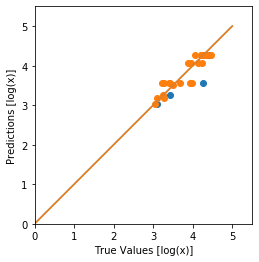

In [21]:
plot_prediction(labels['test'], predicts['tr_d3f3_test'])
plot_prediction(labels['train'], predicts['tr_d3f3_train'])

In [22]:
results.sort_values('test_mse')

,config,test_mse,test_mae,test_r2,train_mse,train_mae,train_r2
6,svr_rbf,0.103446,0.304163,0.630090,8.398443e-03,8.714380e-02,0.958940
5,tr_d3f3,0.107973,0.217111,0.613900,3.527733e-02,1.466256e-01,0.827529
8,svr_linear,0.113713,0.326297,0.593375,9.079338e-03,9.318071e-02,0.955611
9,linear_reg,0.125316,0.337756,0.551885,1.452221e-30,1.009294e-15,1.000000
7,svr_poly,0.168674,0.392031,0.396839,3.309167e-02,1.437455e-01,0.838215
4,tr_d3f1,0.218170,0.333336,0.219848,2.477931e-02,1.169373e-01,0.878854
3,tr_default,0.533701,0.587060,-0.908456,0.000000e+00,0.000000e+00,1.000000
1,nnr_41,0.717315,0.693850,-1.565039,4.539682e-01,3.819272e-01,-1.219452
0,nnr_82,0.999870,0.837292,-2.575427,2.334048e-01,3.713074e-01,-0.141117
2,nnr_20,1.149392,0.802560,-3.110101,3.651989e-01,3.478929e-01,-0.785459


In [23]:
for i in linear_reg.coef_.argsort()[-5:][::-1]:
    print(i, normed_test_data.columns[i], linear_reg.coef_[i])

31 tweet_rt_std_3 0.5002862648258279
27 tweet_per_user_std_3 0.3812269315989635
15 tweet_rt_std_1 0.37709398029293734
18 tweet_per_user_mean_2 0.3357138951180257
23 tweet_rt_std_2 0.32751776919933756
